In [1]:
import sys
sys.path.append('./codes/forgraph/')
from config import args
from sklearn.metrics import roc_auc_score
from models import GCN
from metrics import *
import numpy as np
from Explainer import Explainer
from scipy.sparse import coo_matrix,csr_matrix
import networkx as nx
skip = 5
topk = 5
import matplotlib
import matplotlib.pyplot as plt
import pickle as pkl


args.elr = 0.005
args.coff_t0=5.0
args.coff_t0=1.0
args.coff_size = 0.03
args.coff_ent = 0.01



In [2]:
with open('./dataset/BA-2motif.pkl','rb') as fin:
    adjs,features,labels = pkl.load(fin)

model = GCN(input_dim=features.shape[-1], output_dim=labels.shape[1])
model.load_weights(args.save_path+args.dataset)


embs = model.getNodeEmb((tf.convert_to_tensor(features,dtype=tf.float32),\
                               tf.convert_to_tensor(adjs,dtype=tf.float32)), training=False)
outputs = model.call((tf.convert_to_tensor(features,dtype=tf.float32),\
                            tf.convert_to_tensor(adjs,dtype=tf.float32)),training=False)
pred_label = tf.argmax(outputs, 1)


embs = model.getNodeEmb((tf.convert_to_tensor(features,dtype=tf.float32),\
                               tf.convert_to_tensor(adjs,dtype=tf.float32)), training=False)
outputs = model.call((tf.convert_to_tensor(features,dtype=tf.float32),\
                            tf.convert_to_tensor(adjs,dtype=tf.float32)),training=False)
pred_label = tf.argmax(outputs, 1)


In [3]:
if args.setting==1:
    allnodes = [i for i in range(0,100)]
elif args.setting==2:
    allnodes = [i for i in range(0,100)]
    allnodes.extend([i for i in range(500,600)])
elif args.setting==3:
    allnodes=[i for i in range(1000)]
explainer = Explainer(model=model,nodesize=adjs.shape[1])
optimizer = tf.keras.optimizers.Adam(learning_rate=args.elr)


In [4]:
def acc(adj,insert):
    mask = explainer.masked_adj.numpy()
    adj = coo_matrix(adj)
    for r,c in list(zip(adj.row,adj.col)):
        if r>=insert and r<insert+skip and c>=insert and c<insert+skip:
            reals.append(1)
        else:
            reals.append(0)
        preds.append(mask[r][c])

In [5]:
def plot(adj,label,graphid):
    after_adj_dense = explainer.masked_adj.numpy()

    after_adj = coo_matrix(after_adj_dense)

    rcd = np.concatenate(
        [np.expand_dims(after_adj.row, -1), np.expand_dims(after_adj.col, -1), np.expand_dims(after_adj.data, -1)], -1)
    pos_edges = []
    filter_edges = []

    edge_weights = np.triu(after_adj_dense).flatten()

    sorted_edge_weights = np.sort(edge_weights)
    thres_index = max(int(edge_weights.shape[0] - topk), 0)
    thres = sorted_edge_weights[thres_index]

    for r, c, d in rcd:
        if r<c:
            continue
        if d >= thres:
            pos_edges.append((r, c))
        filter_edges.append((r, c))

    G = nx.from_numpy_matrix(adj)
    pos = nx.kamada_kawai_layout(G)

    colors = ['orange', 'lime', 'red', 'blue', 'maroon', 'brown', 'darkslategray', 'paleturquoise', 'darksalmon',
              'slategray', 'mediumseagreen', 'mediumblue', 'orchid']

    # nodes

    nmb_nodes = after_adj_dense.shape[0]

    node_filter = []
    for node in range(nmb_nodes):
        if node in G.nodes():
            node_filter.append(node)

    nx.draw_networkx_nodes(G, pos,
                           nodelist=node_filter,
                           node_color=colors[0],
                           node_size=300)

    nx.draw_networkx_edges(G, pos, width=2, edge_color='grey')

    nx.draw_networkx_edges(G, pos,
                           edgelist=pos_edges,
                           width=7)

    plt.axis('off')
    plt.show()
    plt.clf()


In [6]:
def explain_graph(gid):
    fea,emb,adj,label,graphid = features[gid], embs[gid], adjs[gid], labels[gid], gid
    explainer((fea,emb,adj,1.0,label))
    insert = 20
    acc(adj,insert)

In [7]:
def test():
    global preds
    global reals
    preds = []
    reals = []
    for gid in allnodes:
        explain_graph(gid)
    auc = roc_auc_score(reals,preds)
    return auc

In [8]:

def train():
    epochs = args.eepochs
    t0 = args.coff_t0
    t1 = args.coff_te

    for epoch in range(epochs):
        loss = 0
        tmp = float(t0 * np.power(t1 / t0, epoch /epochs))
        train_instances = [ins for ins in range(adjs.shape[0])]
        np.random.shuffle(train_instances)
        for gid in train_instances:
            with tf.GradientTape() as tape:
                pred = explainer((features[gid],embs[gid],adjs[gid],tmp, labels[gid]),training=True)
                loss += explainer.loss(pred, pred_label[gid])
        train_variables = [para for para in explainer.trainable_variables
                           if para.name.startswith('explainer')]
        grads = tape.gradient(loss, train_variables)
        optimizer.apply_gradients(zip(grads, train_variables))
        if epoch%1==0:
            print('epoch',epoch,'loss',loss.numpy())
            auc = test()
            print('auc',auc)


In [9]:
train()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch 0 loss 12289.127
auc 0.6985546046803752
epoch 1 loss 12188.328
auc 0.6809117555763702
epoch 2 loss 12090.427
auc 0.6846986545554877
epoch 3 loss 11999.232
auc 0.6837254672388255
epoch 4 loss 11920.585
auc 0.693875863139322
epoch 5 loss 11839.068
auc 0.6942112258938167
epoch 6 loss 11770.472
auc 0.7329305349830095
epoch 7 loss 11694.972
auc 0.7778967128096774
epoch 8 loss 11614.394
auc 0.8165177728645697
epoch 9 loss 11535.102
auc 0.880202774207836
epoch 10 loss 11452.633
auc 0.9264060276349801
epo

In [10]:
auc = test()
print(auc)

0.949085898245767


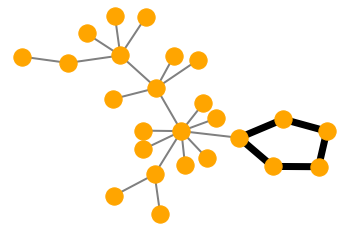

<Figure size 432x288 with 0 Axes>

In [11]:
gid = 5
fea,emb,adj,label,graphid = features[gid], embs[gid], adjs[gid], labels[gid], gid
explainer((fea,emb,adj,1.0,label))
plot(adj,label,graphid)
